# Twitter API & Exploratory Data Analysis

Developed by: Surya Bhattarai
Date: 6 January 2020

This model follows the guidelines provided by the FreeCodeCamp.org available at: https://www.youtube.com/watch?v=1gQ6uG5Ujiw&t=27s

Please note that this model has not gone through extensive finetuning to refine the sentimental analysis outcome.

## 1. Importing Packages

In [3]:
from tweepy import API
from tweepy import Cursor
from tweepy import OAuthHandler
from tweepy import Stream
from tweepy.streaming import StreamListener
from textblob import TextBlob
from scipy import stats
from datetime import datetime
from pandas.tseries.offsets import MonthEnd
from numpy.random import RandomState
import seaborn as sns
from scipy.stats import skew
from scipy import stats
from scipy.stats.stats import pearsonr
from scipy.stats import norm

import numpy as np
import pandas as pd
#import matplotlib as plt
import matplotlib.pyplot as plt
import re

import sqlite3

In [4]:
#import twitter_credentials

## 2. Authentication Keys

In [5]:
CONSUMER_KEY=""
CONSUMER_SECRET=""
ACCESS_TOKEN=""
ACCESS_TOKEN_SECRET=""

## 3. Twitter Client

In [50]:
class TwitterClient():
    
    # passing the twitter user object and defaulting to none (picks your own timeline)
    def __init__(self, twitter_user=None):
        self.auth = TwitterAuthenticator().authenticate_twitter_app()
        self.twitter_client = API(self.auth)
        
        self.twitter_user = twitter_user
        
    def get_twitter_client_api(self):
        return self.twitter_client
    
    def get_user_timeline_tweets(self, num_tweets):
        tweets = []
        
        # passing the twitter client to get the user timeline tweets.
        for tweet in Cursor(self.twitter_client.user_timeline, id=self.twitter_user).items(num_tweets):
            tweets.append(tweet)
        return tweets
    
    def get_friend_list(self, num_friends):
        friend_list = []
        for friend in Cursor(self.twitter_client.friends, id=self.twitter_user).items(num_friends):
            friends_list.append(friend)
        return friend_list
    
    def get_home_timeline_tweets(self, num_tweets):
        home_timeline_tweets = []
        for tweet in Cursor(self.twitter_client.home_timeline, id=self.twitter_user).items(num_tweets):
            home_timeline_tweets.append(tweet)
        return home_timeline_tweets

In [7]:
### TWITTER AUTHENTICATOR ###

class TwitterAuthenticator():
    
    def authenticate_twitter_app(self):
                
        auth = OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
        auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)
        
        return auth

## 4. Twitter streamer and listener

In [8]:
### TWITTER STREAMER
#Class for streaming and processing live tweets
class TwitterStreamer():
    
    def __init__(self):
        self.twitter_authenticator = TwitterAuthenticator()
    
    # this handles twitter authentication and connection to the Twitter API
    def stream_tweets(self, fetched_tweets_filename, hash_tag_list):
        
        listener = TwitterListener(fetched_tweets_filename)
        auth = self.twitter_authenticator.authenticate_twitter_app()
        stream = Stream(auth, listener)
        
        # This line filter twitter stream to capture data by the keywords
        stream.filter(track=hash_tag_list) 

In [9]:
# TWITTER STREAM LISTENER
#This is a basic listener class that just prints received tweets to stdout
class TwitterListener(StreamListener):
    
    #Object to write the tweets to a file
    def __init__(self, fetched_tweets_filename):
        self.fetched_tweets_filename = fetched_tweets_filename
    
    #Object to handle possible errors
    def on_data(self, data):
        try:
            print(data)
            #writes the error to the file
            with open(self.fetched_tweets_filename, 'a') as tf:
                tf.write(data)
            return True
        except BaseException as e:
            print('Error on data: ', str(e))
        return True
            

    def on_error(self, status):
        if status ==420:
            # Returning false on_data method in case rate limit occurs.
            return False
        print(status)

## 5. Capturing tweet responses

In [10]:
#Functionality fo ranalysing and caterogising content from tweets

class TweetAnalyser():
    
    #clean the tweet by removing special characters and hyperlinks
    def clean_tweet(self, tweet):
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())
    
    # Takes the tweet and returns sentiment
    def analyse_sentiment(self, tweet):
        analysis = TextBlob(self.clean_tweet(tweet))
        
        #polarity is a sentiment matrix in TextBlob
        if analysis.sentiment.polarity > 0: # if sentiment is positive
            return 1
        elif analysis.sentiment.polarity == 0: # if sentiment is neutral
            return 0
        else:
            return -1 # if sentiment is negative
    
    def tweets_to_data_frame(self, tweets):
        df = pd.DataFrame(data=[tweet.text for tweet in tweets], columns=['tweets'])
        
        df['id'] = np.array([tweet.id for tweet in tweets])
        df['username'] = np.array([tweet.user.name for tweet in tweets])
        df['len'] = np.array([len(tweet.text) for tweet in tweets])
        df['datetime'] = np.array([tweet.created_at for tweet in tweets])
        df['date'] = np.array([d.date() for d in df["datetime"]])
        df['month'] = np.array(pd.to_datetime(df['date']).dt.to_period('M'))
        df['source'] = np.array([tweet.source for tweet in tweets])
        df['likes'] = np.array([tweet.favorite_count for tweet in tweets])
        df['retweets'] = np.array([tweet.retweet_count for tweet in tweets])
        
        return df    

In [32]:
def get_tweets(screen_name):
    
    twitter_client = TwitterClient()
    tweet_analyser = TweetAnalyser()
    api = twitter_client.get_twitter_client_api()
    
    tweets = api.user_timeline(screen_name=screen_name, count=50)
    df = tweet_analyser.tweets_to_data_frame(tweets)
    
    # Adding a new sentiment column and passing the analysis sentiment class on each tweet in the df
    df['sentiment'] = np.array([tweet_analyser.analyse_sentiment(tweet) for tweet in df['tweets']])
    df['tweet_count'] = np.array(1)
    
    # Aggregating data to the daily basis
    #pd.pivot_table(df, index=["id"], columns=["username","date"], values=["tweet_count"], aggfunc=np.sum)
    
    return df

## 6. Authenticating and sending screen names to twitter

In [33]:
#authenticating and connecting to Twitter streaming API
from pandas import DataFrame

if __name__ == "__main__":
    
    user_list = ["Optus", "Telstra", "VodafoneAU", "NBN_Australia","Westpac","CommBank","ANZ_AU","NAB", "EnergyAustralia","aglenergy","originenergy","alintaenergy"]
    raw_tweets = []

    for x in user_list:
        raw_tweets.append(get_tweets(x))


In [34]:
# concat the list of dataframes into one dataframe

all_tweets = pd.concat(raw_tweets)

In [35]:
# Transformation

all_tweets['username'] = all_tweets['username'].str.replace('nbn™ Australia','nbn')
all_tweets['username'] = all_tweets['username'].str.replace('Vodafone Australia','Vodafone')
all_tweets['source'] = all_tweets['source'].str.replace('Salesforce - Social Studio','Salesforce')

In [36]:
# Sorting by the date

all_tweets = all_tweets.sort_values(by=['datetime'], ascending=False)

In [37]:
# Recreate the index

all_tweets.reset_index(drop=True, inplace=True)

## 7. Summarising tweet data

In [38]:
# Summarise data

all_tweets_summary = all_tweets.groupby(['username', 'date'], as_index=False)['tweet_count', 'likes', 'retweets', 'sentiment'].sum()

In [39]:
print(all_tweets_summary)

          username        date  tweet_count  likes  retweets  sentiment
0       AGL Energy  2019-11-18            2      0         2          1
1       AGL Energy  2019-11-19            4      6         1          0
2       AGL Energy  2019-11-21            1      0         0          1
3       AGL Energy  2019-11-25            2     11         0          0
4       AGL Energy  2019-11-27            2     21         2          0
5       AGL Energy  2019-11-28            1      3         0         -1
6       AGL Energy  2019-11-29            1      0         0          1
7       AGL Energy  2019-12-02            2      4         1          1
8       AGL Energy  2019-12-03            1      8         3          1
9       AGL Energy  2019-12-04            2     11        10          1
10      AGL Energy  2019-12-05            2      4         0          0
11      AGL Energy  2019-12-06            2     11         1         -1
12      AGL Energy  2019-12-09            3     12         3    

In [40]:
print(type(all_tweets_summary))

<class 'pandas.core.frame.DataFrame'>


## 8. Preparing train and test data

In [51]:
# Preparing train and test data

rng = RandomState()

train = pd.DataFrame(all_tweets_summary.sample(frac=0.9, random_state=rng))
test = pd.DataFrame(all_tweets_summary.loc[~all_tweets_summary.index.isin(train.index)])

## 9. Exploratory Data Analysis

In [52]:
# Checking the data types
train.dtypes

username       object
date           object
tweet_count     int64
likes           int64
retweets        int64
sentiment       int64
dtype: object

In [53]:
train.describe()

tweet_count       likes    retweets   sentiment
count   138.000000  138.000000  138.000000  138.000000
mean      4.007246    4.869565    1.702899    0.681159
std       6.281123   19.068768    7.015530    1.579917
min       1.000000    0.000000    0.000000   -3.000000
25%       1.000000    0.000000    0.000000    0.000000
50%       2.000000    0.000000    0.000000    1.000000
75%       4.000000    3.000000    0.750000    1.000000
max      49.000000  201.000000   73.000000    8.000000

In [54]:
company_info = pd.DataFrame(train.groupby('username')[['tweet_count', 'sentiment']].std())
print(company_info)

                 tweet_count  sentiment
username                               
AGL Energy          0.881287   0.979796
ANZ Australia       3.620927   2.806738
Alinta Energy       0.879394   0.871780
CommBank            1.414214   2.828427
EnergyAustralia     3.090693   1.473577
NAB                 2.733629   1.328020
Optus              12.727922   6.363961
Origin              1.109400   0.960769
Telstra            33.941125   2.121320
Vodafone            2.973961   1.316561
Westpac Bank        2.035401   1.812654
nbn                 8.485281   1.414214


Text(0, 0.5, 'Std Dev')

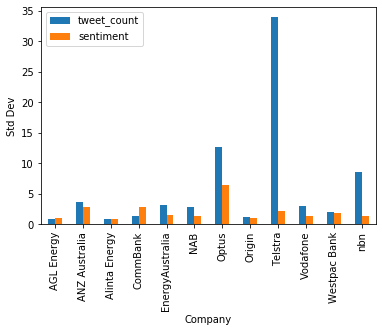

In [55]:
company_info.plot.bar()
plt.xlabel('Company')
plt.ylabel('Std Dev')

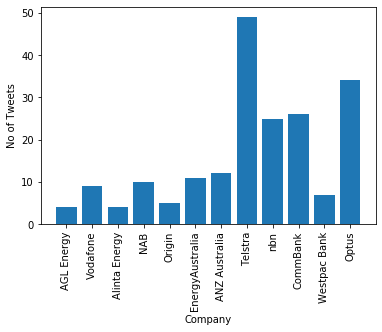

In [57]:
plt.bar(train['username'], train['tweet_count'])
plt.xticks(rotation=90)
plt.xlabel('Company')
plt.ylabel('No of Tweets')
plt.show()


 mu = 1.03 and sigma = 2.11



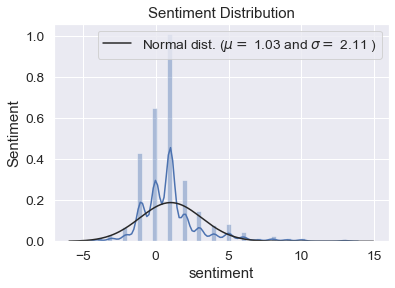

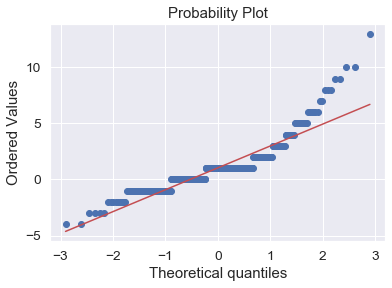

Skewness: 1.734718
Kurtosis: 5.431024


In [72]:
# Plot Histogram to see the distribution

sns.distplot(train['sentiment'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['sentiment'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Sentiment')
plt.title('Sentiment Distribution')

fig = plt.figure()
res = stats.probplot(train['sentiment'], plot=plt)
plt.show()

print("Skewness: %f" % train['sentiment'].skew())
print("Kurtosis: %f" % train['sentiment'].kurt())

In [49]:
# Checking Categorical Data
train.select_dtypes(include=['object']).columns

Index(['username', 'date'], dtype='object')

In [50]:
# Checking Numerical Data
train.select_dtypes(include=['int64','float64']).columns

Index(['tweet_count', 'likes', 'retweets', 'sentiment'], dtype='object')

In [51]:
cat = len(train.select_dtypes(include=['object']).columns)
num = len(train.select_dtypes(include=['int64','float64']).columns)
print('Total Features: ', cat, 'categorical', '+',
      num, 'numerical', '=', cat+num, 'features')

Total Features:  2 categorical + 4 numerical = 6 features


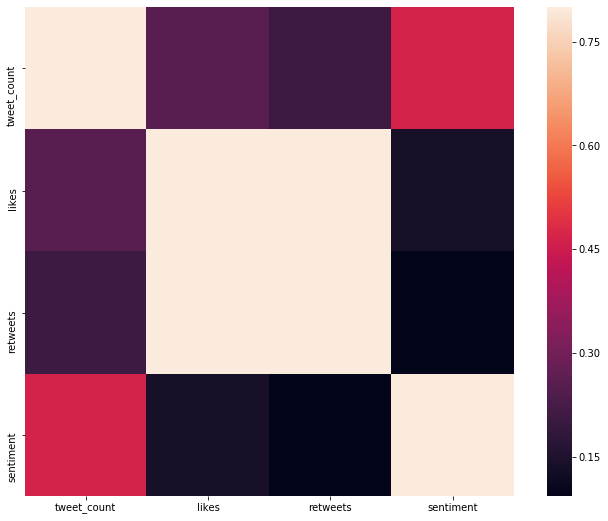

In [46]:
# Correlation Matrix Heatmap

corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

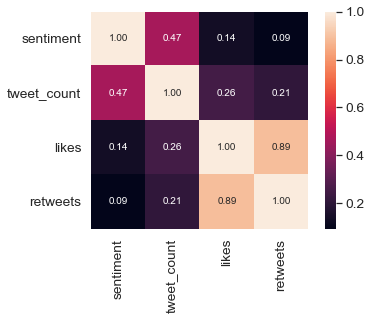

In [55]:
# Top 10 Heatmap
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'sentiment')['sentiment'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [56]:
most_corr = pd.DataFrame(cols)
most_corr.columns = ['Most Correlated Features']
most_corr

Most Correlated Features
0                sentiment
1              tweet_count
2                    likes
3                 retweets

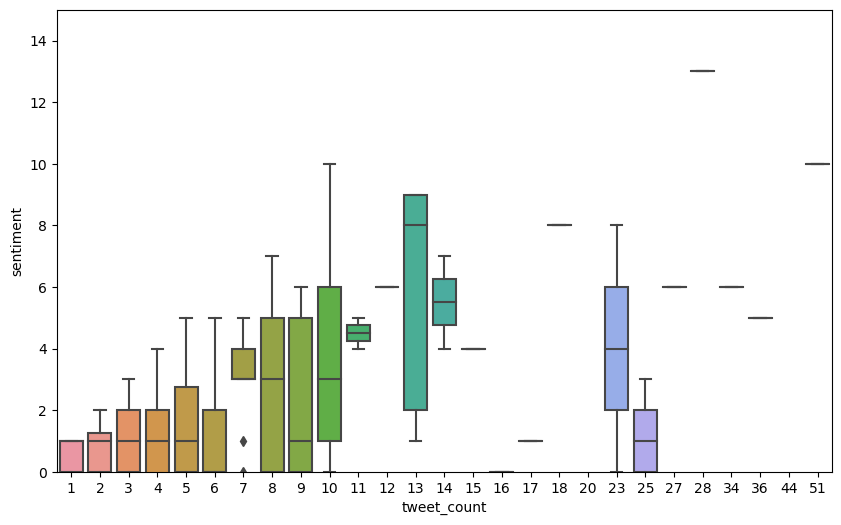

In [92]:
# Overall tweet count vs sentiment
var = 'tweet_count'
data = pd.concat([train['sentiment'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(10, 6))
fig = sns.boxplot(x=var, y="sentiment", data=data)
fig.axis(ymin=0, ymax=15);